<a href="https://colab.research.google.com/github/brenoskuk/ML_exercises/blob/master/my_kNN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Practical Assignement 2 - "k-Nearest Neighbors"**
Bruno Skuk et Leonardo Boulitreau


## Library


In [ ]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # for plots
from matplotlib.colors import ListedColormap
from matplotlib import rc

import seaborn as sns
from random import random
import time

MAX_DIST = 99999999 # the maximum distance is defined here

%matplotlib inline
np.random.seed(seed=666)

#Question 1

Here we will implement the KNN algorithm to deal with labeled data. The first question concerns artificially generated gaussian data with different means in a 2d plane.

## Part 1


### Generating Datasets

The generation of data follows the same logic as in TP4. 


In [ ]:
def gaussian_data_generation(n, mean, cov):
  # create data which follows a multivariate Gaussian distribution

  assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"    
  assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"

  X = np.random.multivariate_normal(mean, cov, n) # actual data
    
  return X

The following function creates the needed distributions for question 1.



In [ ]:
def generate_data_cov(cov = 0.10):
    
  cov_I = np.array([[cov, 0], [0, cov]])

  n=100 # same number of samples for each class

  mean_0 = [-1, 0]        
  mean_1 = [1, 0]
  mean_2 = [0, 1]

  X_0=gaussian_data_generation(n, mean_0, cov_I)
  y_0=np.zeros(n, dtype = int)

  X_1=gaussian_data_generation(n, mean_1, cov_I)
  y_1=np.ones(n, dtype = int)

  X_2=gaussian_data_generation(n, mean_2, cov_I)
  y_2=2*np.ones(n, dtype = int)

  X=np.concatenate((X_0,X_1,X_2))
  y=np.concatenate((y_0,y_1,y_2))
        
  return X, y

The following functions plot the data.

In [ ]:
def plot_data(X,y):
  fig1 = plt.figure(figsize=(6, 6))
  ax = plt.gca()
  min_tot = np.min(X)
  max_tot = np.max(X)
  symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
  k = np.unique(y).shape[0]
  color_blind_list = sns.color_palette("colorblind", k)
  for i, label in enumerate(y):
      plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                  s=80, marker=symlist[int(label)])
  plt.show()

We will work over the following data:

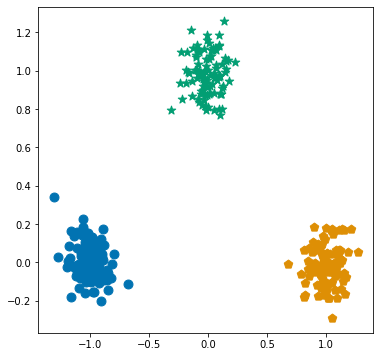

In [ ]:
X, y = generate_data_cov(0.01)
plot_data(X,y)

As demanded, the dataset is split. Here we do it manually.

In [ ]:
def split_dataset(X,y):

  X_train=np.concatenate((X[0:67], X[100:167], X[200:266]))
  y_train=np.concatenate((y[0:67], y[100:167], y[200:266]))

  X_test=np.concatenate((X[67:100], X[167:200], X[266:300]))
  y_test=np.concatenate((y[67:100], y[167:200], y[266:300]))

  
  return X_train,y_train,X_test,y_test 

The size of X_train is: 200
The size of X_train is: 100


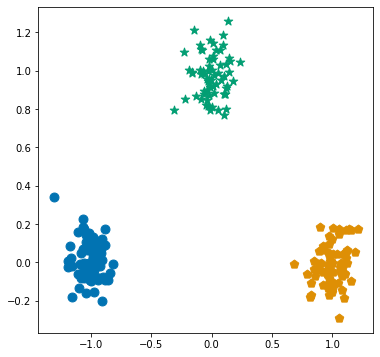

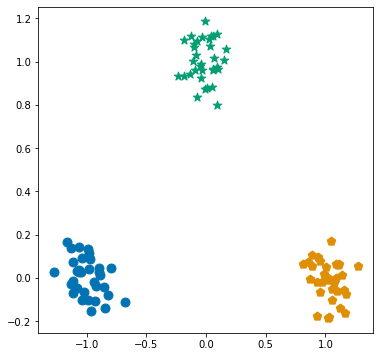

In [ ]:
X_train,y_train,X_test,y_test = split_dataset(X,y)
print("The size of X_train is:", len(X_train))
print("The size of X_train is:", len(X_test))
plot_data(X_train, y_train)
plot_data(X_test,y_test)


### KNN Algorithm

The algorithm is based upon the instructions given in the TP5. Here it has been generalized to take a set of features belonging to $\mathbb{R}^d$ of lenght $n$, a set of labels of lenght $n$, a point $p$, and extract the k nearest neighbors of a point p in the form of their indexes, and classify the point based upon the most same label count. This implementation allows for doing the Knn for question 1, 2 and 3, as if the labels are not needed like in question 2, we only need to ignore this classification and work over the list of neighbors.

The algorithm was implemented in the following way:

An array of distances is initialized with a maximal distance.

For each point in the dataset calculates the distance to $p$. This is done using a metric of order 2, but we could tweak this parameter. If the distance is lower than the highest distance of the array of distances, it will enter the array, 'popping' the last position and inserting the new distance. Then, the distance 'descends' the array in a bubble sort manner, to it's correct position.

This garantees that this step of the algorithm is done in $O(n)$.

In [ ]:
def knn(p, X, Y, k, ord_type = 2): # given point p, set of points X, corresponding labels Y, returns knn using norm of order 2 by default 
  k_neighs = np.zeros(k, dtype=int) # initializes array with index of knn
  distances = MAX_DIST*np.ones(k) # MAX_DIST is a constant previously defined
  label_count = np.zeros(np.amax(Y) + 1, dtype=int) # considers the number of labels to be the max of Y plus the zero label
  
  for i in range(X.shape[0]): # exhaustif search of neighbors
    dist = np.linalg.norm(p-X[i], ord = ord_type) # see https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    #print("dist ", i, " = ", dist, "label = ", Y[i] ,"\n")
    if dist <= distances[k-1]: # will only enter list of knn if its smaller than highest distace
      distances[k-1] = dist
      k_neighs[k-1] = i
      j = k - 1
      while distances[j-1] > dist and j >= 1: # the distance and index descends knn array to correct position 
        temp_dist = distances[j-1]
        temp_ind = k_neighs[j-1]
        distances[j-1] = distances[j]
        k_neighs[j-1] = k_neighs[j]
        distances[j] = temp_dist
        k_neighs[j] = temp_ind
        j = j - 1
  # finally counts labels and makes decision
  #print(k_neighs)
  for i in range(k):
    label_count[Y[k_neighs[i]]] += 1 
  #print ("\nlabel count = ", label_count, "\n")
  classification = np.where(label_count == np.amax(label_count))[0][0]
  return classification, k_neighs

Using the previous function, we find the label for a set of features of size $m$, given a training set of features and labels.  

The time to compute all the algorithm is then $O(m\times n)$. 


In [ ]:
def classify_knn_data(X_test, X_train, Y_train, k): # uses function above to classify set of points
  n = X_test.shape[0]
  Y_out = np.zeros(n , dtype=int)
  for i in range(n):
    Y_out[i],_ = knn(X_test[i],X_train, Y_train, k = k)
  return Y_out


### Error counting 

Simple function to calculate errors.

In [ ]:
def calculate_errors(Y_out,Y_test):
  n_errors = 0
  for i in range(Y_test.shape[0]):
    if Y_out[i] != Y_test[i]:
      n_errors += 1
  return n_errors

### Decision boundary

The decision boundary is calculated using a grid. We proceed to find wich label is given to each point of the grid.

In [ ]:
def decision_boundary(X, y, k = 5 ,step=50):
    # decision boundary of classifier knn
    symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
    
    # construct cmap
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    
    # classifying Cmap
    z = np.array([knn(vec, X, y, k)[0] for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", alpha=0.80, cmap=my_cmap)

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    for i, label in enumerate(y):
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                    s=80, marker=symlist[int(label)])
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    plt.show()


### Generating set, classification and results

Here we apply the previous functions to obtain the results.

In [ ]:
cov_part_1 = 0.10
X, y = generate_data_cov(cov_part_1)
X_train, Y_train, X_test, Y_test = split_dataset(X, y)

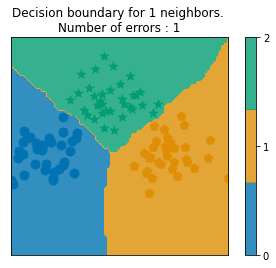

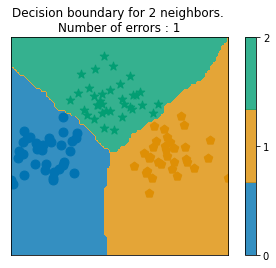

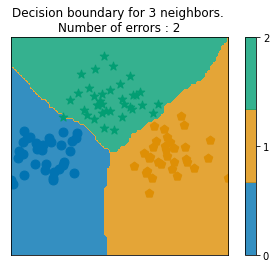

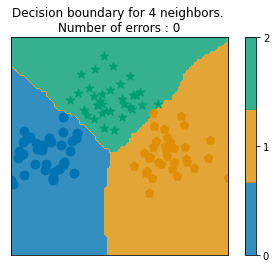

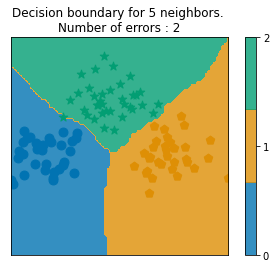

In [ ]:
resolution_param = 80 # adjust for better plot (higher computation time)

for i in range(5):
  k = i + 1
  Y_out = classify_knn_data(X_test, X_train, Y_train, k)
  title = "Decision boundary for " + str(k) + " neighbors. \nNumber of errors : " + str(calculate_errors(Y_out,y_test))
  plt.title(title)
  decision_boundary(X_test, Y_out, step=resolution_param)

### Results: 

As we can see, for the given distribution of low variance, where points of a distribution rarely mix, the decision boundary isn't affected by the number of neighbors, and the number of errors isn't, at first sight, correlated with the number of neighbors, as we observe that they stay almost the same between experiments. 

##Part 2

Defining function that takes a covariance, a number of neighbors and calculates the average error and standard deviation for 50 different datasets.

In [ ]:
def test_50_times(cov,k):
  n_errors = np.zeros(50)
  # count errors for 50 iterations
  for i in range(50):
    # generate each test set for a given covariance
    cov_part_1 = 0.10
    X, y = generate_data_cov(cov)
    X_train, Y_train, X_test, Y_test = split_dataset(X, y)
    # Run the knn classification
    Y_out = classify_knn_data(X_test, X_train, Y_train, k)
    
    # get for each iterations the errors
    it_err = calculate_errors(Y_out,y_test)
    n_errors[i] = it_err

  avg_error = n_errors.sum()/50
  # calculates the standard deviation of errors
  std_dev = 0
  for i in range(50):
    std_dev = std_dev + (n_errors[i] - avg_error)**2
  std_dev = (1/50*std_dev)**(0.5)
  return avg_error, std_dev

### Measuring errors with different variances

In [ ]:
# 1 neighbors
e5k1, std_5k1 = test_50_times(0.05, 1)
e10k1, std_10k1 = test_50_times(0.10, 1)
e15k1, std_15k1 = test_50_times(0.15, 1)
e20k1, std_20k1 = test_50_times(0.20, 1)
e25k1, std_25k1 = test_50_times(0.25, 1)

In [ ]:
# 2 neighbors
e5k2, std_5k2 = test_50_times(0.05, 2)
e10k2, std_10k2 = test_50_times(0.10, 2)
e15k2, std_15k2 = test_50_times(0.15, 2)
e20k2, std_20k2 = test_50_times(0.20, 2)
e25k2, std_25k2 = test_50_times(0.25, 2)

In [ ]:
# 10 neighbors
e5k10, std_5k10 = test_50_times(0.05, 10)
e10k10, std_10k10 = test_50_times(0.10, 10)
e15k10, std_15k10 = test_50_times(0.15, 10)
e20k10, std_20k10 = test_50_times(0.20, 10)
e25k10, std_25k10 = test_50_times(0.25, 10)

### Plots

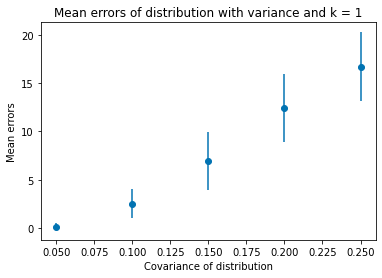

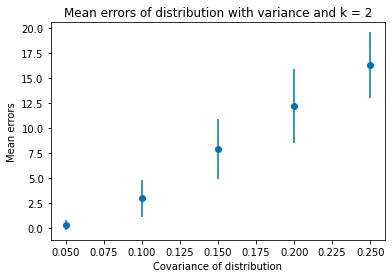

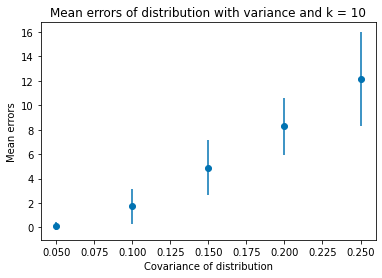

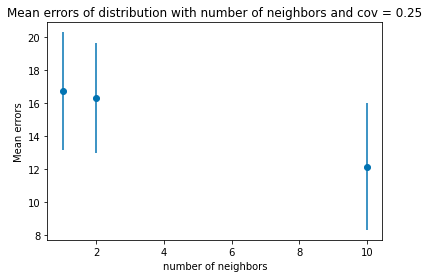

In [ ]:
x = np.array([0.05, 0.10, 0.15, 0.20, 0.25])
y = np.array([e5k1,e10k1,e15k1,e20k1,e25k1])
d = np.array([std_5k1,std_10k1,std_15k1,std_20k1,std_25k1])

plt.errorbar(x, y, d, linestyle='None', marker='o')
plt.title("Mean errors of distribution with variance and k = 1")
plt.xlabel("Covariance of distribution")
plt.ylabel("Mean errors")
plt.show()

x = np.array([0.05, 0.10, 0.15, 0.20, 0.25])
y = np.array([e5k2,e10k2,e15k2,e20k2,e25k2])
d = np.array([std_5k2,std_10k2,std_15k2,std_20k2,std_25k2])

plt.errorbar(x, y, d, linestyle='None', marker='o')
plt.title("Mean errors of distribution with variance and k = 2")
plt.xlabel("Covariance of distribution")
plt.ylabel("Mean errors")
plt.show()

x = np.array([0.05, 0.10, 0.15, 0.20, 0.25])
y = np.array([e5k10,e10k10,e15k10,e20k10,e25k10])
d = np.array([std_5k10,std_10k10,std_15k10,std_20k10,std_25k10])

plt.errorbar(x, y, d, linestyle='None', marker='o')
plt.title("Mean errors of distribution with variance and k = 10")
plt.xlabel("Covariance of distribution")
plt.ylabel("Mean errors")
plt.show()



x = np.array([1, 2, 10])
y = np.array([e25k1,e25k2,e25k10])
d = np.array([std_25k1,std_25k2,std_25k10])

plt.errorbar(x, y, d, linestyle='None', marker='o')
plt.title("Mean errors of distribution with number of neighbors and cov = 0.25")
plt.xlabel("number of neighbors")
plt.ylabel("Mean errors")
plt.show()

### Results: 

The number of errors increases as the covariance of distribution increases. This is expected as the probability of misclassification increases  for the same k, as a ball centered around the classification point will most likely have points that will induce an error in classification. 

Mantaining covariance constant, and increasing K, however, diminishes the error. This is due to the fact that for the same point $p$, the ball around it increases in size and thus, it's less likely that there are more points belonging to the 'wrong' distributions that those belonging to the 'correct' one. 


#Question 2

First, we upload the dataset to work on drive. 

In [ ]:
# FOR USE ON GOOGLECOLAB ONLY (UNNECESARY IF RUNNING NOTEBOOK LOCALLY)
from google.colab import files 
uploaded = files.upload() # select csv from files and upload

Saving weatherHistory.csv to weatherHistory.csv


In [ ]:
import io

# COMMENT IF RUNNING LOCALLY
df = pd.read_csv(io.BytesIO(uploaded['weatherHistory.csv']))

# UNCOMMENT IF RUNNING NOTEBOOK LOCALLY
#df = pd.read_csv('weatherHistory.csv')

# Dataset is now stored in a Pandas Dataframe

Once the dataset is available, we see it's head to know the format.

In [ ]:
df.head() 



,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


##Part 1

We are interested only in three columns, of wich nan values are eliminated.

In [ ]:
y = df.dropna()['Apparent Temperature (C)'] 
x1 = df.dropna()['Temperature (C)']
x2 = df.dropna()['Humidity']


### Plotting data

A scatter plot is done. Temperature is on the 'x' axis while humidity is in the 'y' axis. To represent Apparent temperature, a scale of color is used.

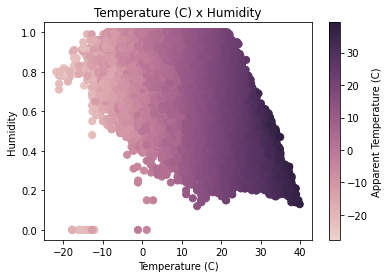

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
ff, ax = plt.subplots()
pp = ax.scatter(x1,x2,c=y, s = 50, cmap=cmap)
cb = plt.colorbar(pp)
cb.set_label('Apparent Temperature (C)')

plt.title("Temperature (C) x Humidity")
plt.ylabel("Humidity")
plt.xlabel("Temperature (C)")


plt.show()

### Results:

As we can observe, there seems to be a 'spatial' correlation between the space of Temperature and Humidity to the Apparent Temperature. The hotter the day, the lesser the humidity (there seem to be outliars with humidity zero, but they probably won't affect the KNN algorithm. 

##Part 2

As the number of iterations increases too much with the size of the analysed set, we will work only over 2000 samples. We shuffle the data after the separation (shuffling before separating the 2000 samples could also be useful to avoid getting data from only a certain period of time). 

In [ ]:
# Getting only first 2000 samples 
N = 2000
y_q = np.array(y[:N])
x1_q = np.array(x1[:N])
x2_q = np.array(x2[:N])

# creating array of coordinates
X = np.stack((x1_q,x2_q),axis=-1)

# Shuffling data
shuffle_order = np.arange(N)
np.random.shuffle(shuffle_order)

y_q = y_q[shuffle_order]
X = X[shuffle_order]

### Knn for temperatures

Knn for temperatures ignore the labeling, and uses only the $k$ indexes of nearest neighbors of a point. The estimated temperature is then set to be the average of the temperatures of the set of KNN.



In [ ]:
def knn_for_temperatures(X_test, X_train, Y_train, k): # uses function above to classify set of points
  n = X_test.shape[0]
  Y_out = np.zeros(n)
  # here we ignore the classification of labels, only finding the neighbours matters
  Y_toy = np.zeros(Y_train.shape[0], dtype=int)
  for i in range(n):
    _,neighs = knn(X_test[i],X_train, Y_toy, k = k) # neighs contains the index of the k nearest neighbours
    sum_k_temperature = 0
    for j in range(k):
      sum_k_temperature += Y_train[neighs[j]]
    Y_out[i] = sum_k_temperature/k # computing the average
  return Y_out

Calculates the error and standard deviation of a 5 fold set, using one fold as testing and the rest as training. 

In [ ]:
def calculate_err_std_dev(X,y_q,k):
  errors = np.zeros(5)
  for i in range(5):
    XX = np.concatenate((X[:400*i], X[400*(i+1):]), axis = 0) # dividing in 4 training folds
    YY = np.concatenate((y_q[:400*i], y_q[400*(i+1):]), axis = 0)
    Y_out = knn_for_temperatures(X[400*i:400*(i+1)],XX,YY,k) # dividing and testing knn for 1 testing fold
    errors[i] = np.sum(np.abs(Y_out - y_q[400*i:400*(i+1)]))/400
  avg_error = np.sum(errors)/5
  # calculates the standard deviation of errors
  std_dev = 0
  for i in range(5):
    std_dev = std_dev + (errors[i] - avg_error)**2
  std_dev = (1/5*std_dev)**(0.5)
  return avg_error, std_dev


In [ ]:
e2k1, std_dev2k1 = calculate_err_std_dev(X,y_q,1)
e2k2, std_dev2k2 = calculate_err_std_dev(X,y_q,2)
e2k3, std_dev2k3 = calculate_err_std_dev(X,y_q,3)
e2k4, std_dev2k4 = calculate_err_std_dev(X,y_q,4)
e2k5, std_dev2k5 = calculate_err_std_dev(X,y_q,5)
e2k6, std_dev2k6 = calculate_err_std_dev(X,y_q,6)
e2k7, std_dev2k7 = calculate_err_std_dev(X,y_q,7)
e2k8, std_dev2k8 = calculate_err_std_dev(X,y_q,8)
e2k9, std_dev2k9 = calculate_err_std_dev(X,y_q,9)
e2k10, std_dev2k10 = calculate_err_std_dev(X,y_q,10)


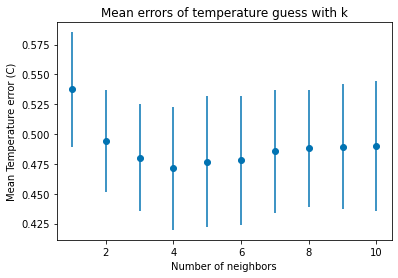

In [ ]:
x = np.array([1,2,3,4,5,6,7,8,9,10])
y = np.array([e2k1,e2k2,e2k3,e2k4,e2k5,e2k6,e2k7,e2k8,e2k9,e2k10])
d = np.array([std_dev2k1,std_dev2k2,std_dev2k3,std_dev2k4,std_dev2k5,std_dev2k6,std_dev2k7,std_dev2k8,std_dev2k9, std_dev2k10])

plt.errorbar(x, y, d, linestyle='None', marker='o')
plt.title("Mean errors of temperature guess with k")
plt.xlabel("Number of neighbors")
plt.ylabel("Mean Temperature error (C)")
plt.show()

### Results: 

The results show that the error is small, and that the method is a good option to predict the apparent temperature. 

Another important point is to note that unlike previously found, increasing the number of neighbors isn't going to better the performance of the classification, and that there may exist an optimal number of neighbors to run the algorithm.

In the following cells we plot the result with k = 4 (found to be the optimal number of neighbors for the current dataset). This shows indeed good results.

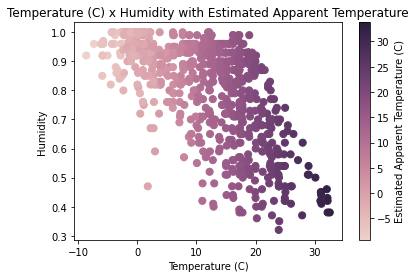

In [ ]:
XX = np.concatenate((X[:400], X[1200:]), axis = 0) # dividing in 4 training folds
YY = np.concatenate((y_q[:400], y_q[1200:]), axis = 0)
Y_out = knn_for_temperatures(X[400:1200],XX,YY,4) # dividing and testing knn for 1 testing fold

XXt = X[400:1200]

cmap = sns.cubehelix_palette(as_cmap=True)
ff, ax = plt.subplots()
pp = ax.scatter(XXt[:,0],XXt[:,1],c=Y_out, s = 50, cmap=cmap)
cb = plt.colorbar(pp)
cb.set_label('Estimated Apparent Temperature (C)')

plt.title("Temperature (C) x Humidity with Estimated Apparent Temperature")
plt.ylabel("Humidity")
plt.xlabel("Temperature (C)")


plt.show()

#Question 3

##Part 1


Now we access the dictionary data and also do the normalisation proposed on the TP assignment document


In [ ]:
# FOR USE ON GOOGLECOLAB ONLY (UNNECESARY IF RUNNING NOTEBOOK LOCALLY)
uploaded = files.upload() # upload both data_test.mat and data_app.mat

Saving data_app.mat to data_app.mat
Saving data_test.mat to data_test.mat


In [ ]:
import scipy.io
# COMMENT IF RUNNING LOCALLY
train = scipy.io.loadmat(io.BytesIO(uploaded['data_app.mat']))
test = scipy.io.loadmat(io.BytesIO(uploaded['data_test.mat']))

# UNCOMMENT IF RUNNING NOTEBOOK LOCALLY
#train = scipy.io.loadmat('data_app.mat')
#test = scipy.io.loadmat('data_test.mat')

In [ ]:
traindata = train['x']
trainlabel = train['S']
testdata = test['x']
testlabel = test['S']

trda = traindata.astype(float)/255
teda = testdata.astype(float)/255

Now we create a function just to transform the line vector onto the shape of an image

In [ ]:
def array2img(x):
    
    y = np.zeros([28,28])
    for i in range(0,27):
        y[i,:] = x[i*28:i*28+28]
    
    return y

As demanded, we visualise some images from the data training set

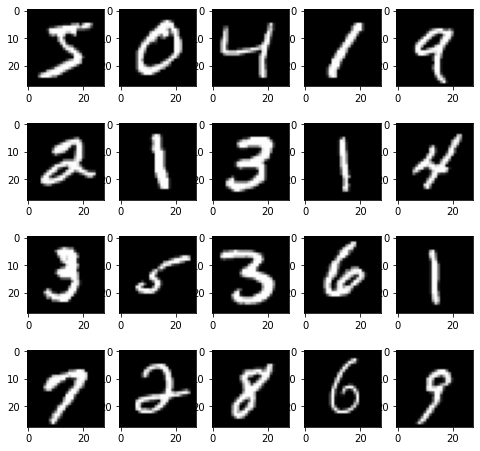

In [ ]:
# Visualize TrainSet

fig = plt.figure(figsize=(8, 8))

for i in range (1,21):
    fig.add_subplot(4, 5, i)
    plt.imshow(array2img(trda[i-1,:]), cmap='gray', vmin=0, vmax=1)
plt.show()

And also from the test set

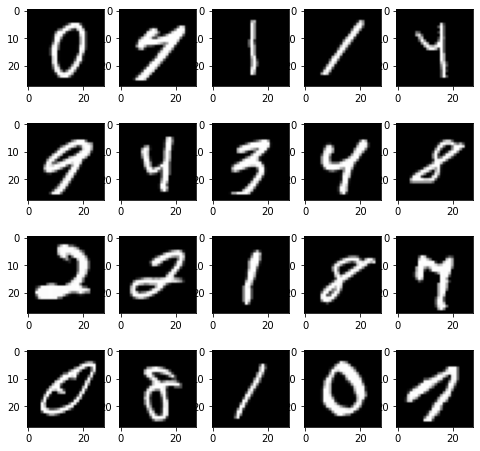

In [ ]:
# Visualize TestSet

fig = plt.figure(figsize=(8, 8))

for i in range (1,21):
    fig.add_subplot(4, 5, i)
    plt.imshow(array2img(teda[i-1,:]), cmap='gray', vmin=0, vmax=1)
plt.show()

Now we plot two histograms from both the train and the test label to analyse both quantities. 

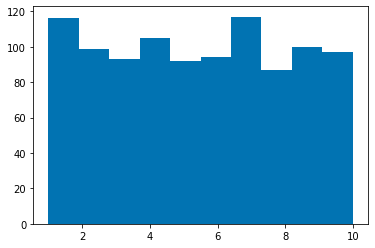

In [ ]:
# Visualize Train Label
plt.hist(trainlabel)
plt.show()

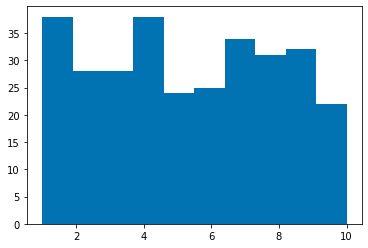

In [ ]:
# Visualize Test Label
plt.hist(testlabel)
plt.show()

From the histograms, we can see that the data is uniformely distributed over all the possible digits

##Part 2

Now wew create a simple function to calculate the euclidean distance of two vectors

In [ ]:
def disteuclid(d1,d2):
    
    d = np.sqrt(np.sum(np.square(d1-d2)))    
    
    return d

We redefine the same knn algorithm just changing the distance equation


In [ ]:
def knn(p, X, Y, k, ord_type = 2): # given point p, set of points X, corresponding labels Y, returns knn using norm of order 2 by default 
  k_neighs = np.zeros(k, dtype=int) # initializes array with index of knn
  distances = MAX_DIST*np.ones(k) # MAX_DIST is a constant previously defined
  label_count = np.zeros(np.amax(Y) + 1, dtype=int) # considers the number of labels to be the max of Y plus the zero label
  
  for i in range(X.shape[0]): # exhaustif search of neighbors
    dist = disteuclid(p,X[i])
    #print("dist ", i, " = ", dist, "label = ", Y[i] ,"\n")
    if dist <= distances[k-1]: # will only enter list of knn if its smaller than highest distace
      distances[k-1] = dist
      k_neighs[k-1] = i
      j = k - 1
      while distances[j-1] > dist and j >= 1: # the distance and index descends knn array to correct position 
        temp_dist = distances[j-1]
        temp_ind = k_neighs[j-1]
        distances[j-1] = distances[j]
        k_neighs[j-1] = k_neighs[j]
        distances[j] = temp_dist
        k_neighs[j] = temp_ind
        j = j - 1
  # finally counts labels and makes decision
  #print(k_neighs)
  for i in range(k):
    label_count[Y[k_neighs[i]]] += 1 
  #print ("\nlabel count = ", label_count, "\n")
  classification = np.where(label_count == np.amax(label_count))[0][0]
  return classification#, k_neighs

Create a function for applying the Knn to a whole set of points

In [ ]:
def classify_knn_data(X_test, X_train, Y_train, k): # uses function above to classify set of points
  n = X_test.shape[0]
  Y_out = np.zeros(n , dtype=int)
  for i in range(n):
    Y_out[i] = knn(X_test[i],X_train, Y_train, k = k)
  return Y_out

Now we run the algorithm over the test sets for k = 1, 3 and 5.

In [ ]:
out1 = classify_knn_data(teda,trda,trainlabel,1)
out3 = classify_knn_data(teda,trda,trainlabel,3)
out5 = classify_knn_data(teda,trda,trainlabel,5)

We create a error function based only on the quantity of measurement of wrong labeled points

In [ ]:
def error(out,testlabel):

    err = 0
    for i in range(0,300):
        if (out[i]!=testlabel[i]):
            err = err+1
        
    return err

Finally we calculate the average error

In [ ]:
print("Error for K=1")
print(error(out1,testlabel)/len(testlabel))
print("Error for K=3")
print(error(out3,testlabel)/len(testlabel))
print("error for K=5")
print(error(out5,testlabel)/len(testlabel))

Error for K=1
0.15333333333333332
Error for K=3
0.18333333333333332
error for K=5
0.17


##Part 3

Now, we create a function of a confusion matrix to evaluate the general performance of the algorithm. It show us not only how many times how the algorithm missclassified, but also how it happened.

In [ ]:
def confusion_matrix(reallabel, predictedlabel):
    
    cf = np.zeros([10,10])
    
    for i in range (0,300):
        for k in range (1,10):        
            if (reallabel[i]==k):
                for j in range (1,10):
                    if (predictedlabel[i]==j):
                        cf[k-1][j-1] +=1
            
    return cf

Apply it to the outputs

In [ ]:
cm1 = confusion_matrix(testlabel,out1)
cm3 = confusion_matrix(testlabel,out3)
cm5 = confusion_matrix(testlabel,out5)

The we just make it more easily readable with a heatmap plot

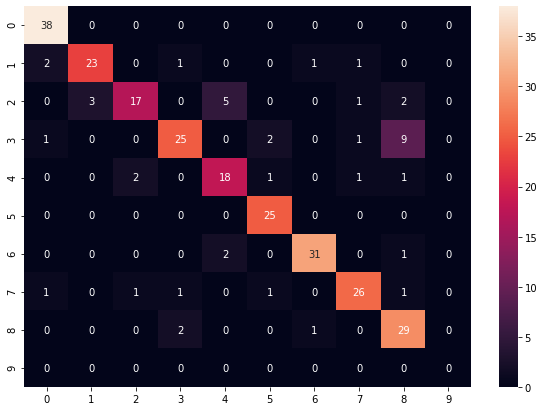

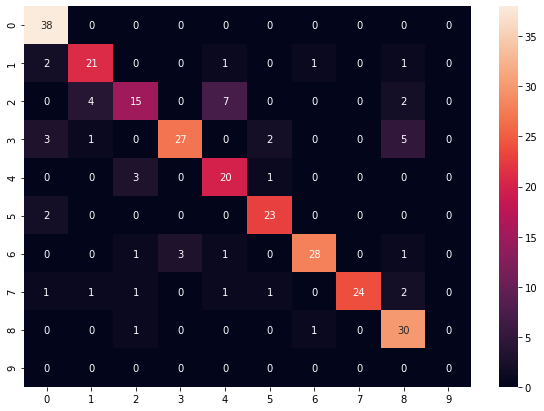

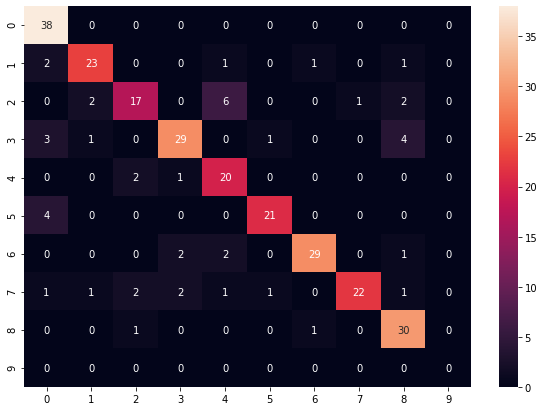

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm1 = pd.DataFrame(cm1, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
df_cm3 = pd.DataFrame(cm3, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
df_cm5 = pd.DataFrame(cm5, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm1, annot=True)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm3, annot=True)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm5, annot=True)